In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from Modules import plot_ax_violin

from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

from Modules import do_scatter_heat

from PyPDF2 import PdfFileWriter, PdfFileReader
import io
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

pdfmetrics.registerFont(TTFont('Arial', 'Arial.ttf'))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [2]:
def add_dataset_features(df_labels):
    
    name_map = {'Lab_Pvalb':'This study GSE142546',
                'Lab_OLM':'Winterer et al. (2019) GSE124847',
                'GSE75386':'Földy et al. (2016) GSE75386',
                'Cadwell':'Cadwell et al. (2016) E-MTAB-4092',
                'GSE70844':'Fuzik et al. (2016) GSE70844',
                'GSE119248':'Muñoz-Manchado et al. (2018) GSE119248',
                'Gouwens':'Gouwens et al. (2020) GSE?????',
                'GSE60361':'Zeisel et al. (2015) GSE60361',
                'GSE99888':'Harris et al. (2018) GSE99888',
                'GSE115746':'Tasic et al. (2018) GSE115746'
               }
    location_map = {'Lab_Pvalb':'Hippocampus',
                    'Lab_OLM':'Hippocampus',
                    'GSE75386':'Hippocampus',
                    'Cadwell':'Cortex',
                    'GSE70844':'Cortex',
                    'GSE119248':'Striatum',
                    'Gouwens':'Cortex',
                    'GSE60361':'Hippocampus',
                    'GSE99888':'Hippocampus',
                    'GSE115746':'Cortex'
                   }
    method_map = {'Lab_Pvalb':'Patch-seq',
                  'Lab_OLM':'Patch-seq',
                  'GSE75386':'Patch-seq',
                  'Cadwell':'Patch-seq',
                  'GSE70844':'Patch-seq',
                  'GSE119248':'Patch-seq',
                  'Gouwens':'Patch-seq',
                  'GSE60361':'FACS-based',
                  'GSE99888':'FACS-based',
                  'GSE115746':'FACS-based'
                 }
    df_labels['Name'] = df_labels.Dataset.map(name_map)
    df_labels['Location'] = df_labels.Dataset.map(location_map)
    df_labels['Method'] = df_labels.Dataset.map(method_map)
    df_labels.loc[np.logical_and(df_labels.Dataset=='GSE60361',
                                 df_labels.index.str.startswith('sscortex')
                                )
                  , 'Location'] = 'Cortex'
    
    return

def get_dataset_labels(dataset, df):
    # get age range
    if dataset in ('Lab_Pvalb', 'Cadwell', 'GSE119248', 'GSE60361', 'GSE99888', 'Lab_OLM'):
        fname = 'References/Cell_Labels_%s.tsv' % dataset
        df_age = pd.read_csv(fname, sep='\t', header=0, index_col=0).loc[df.index.get_level_values('Cell'), ['Age']]
        df_age['High'] = df_age.Age
        df_age.columns = ['Low', 'High']
        df_age = df_age.loc[df.index.get_level_values('Cell'),:]
    else:
        df_age = pd.DataFrame(np.NaN, index=df.index.get_level_values('Cell'), columns=['Low', 'High'])
        if dataset == 'GSE75386':
            df_age.Low = 15
            df_age.High = 28
        elif dataset == 'GSE70844':
            df_age.Low = 17
            df_age.High = 23
        elif dataset == 'GSE115746':
            df_age.Low = 53
            df_age.High = 91
        elif dataset == 'Gouwens':
            df_age.Low = 45
            df_age.High = 70
    
    df_age.index = df.index.get_level_values('CellType')
    columns = ['Dataset', 'Age_Low', 'Age_High']
    df_labels = pd.DataFrame(np.NaN, index=np.unique(df_age.index), columns=columns)
    df_labels.Age_Low = df_age.Low.groupby(df_age.index).min()
    df_labels.Age_High = df_age.High.groupby(df_age.index).max()
    
    # add dataset specific features
    df_labels.Dataset = dataset
    df.index = df.index.get_level_values('CellType')
    
    return df_labels
    
    if dataset in ('Lab_Pvalb', 'Lab_OLM', 'GSE75386', 'Cadwell', 'GSE99888'):
        df_age.Location = 'Hippocampus'
    elif dataset in ('GSE70844', 'GSE115746'):
        df_age.Location = 'Cortex'
    elif dataset in ('GSE119248',):
        df_age.Location = 'Striatum'
    elif dataset in ('GSE60361',):
        df_age.Locatio = 'Hippocampus and Cortex'
    
    df_age['Dataset'] = dataset
    if dataset in ():
        df_age['Method'] = 'Patch-seq'
    else:
        df_age['Method'] = 'FACS-based'
    
    return df_age

def read_hemoglobin_data(dataset, genes=[]):
    df = pd.read_csv('Hemoglobin/%s.tsv' % dataset, sep='\t', header=[0,1], index_col=0)
    
    if len(genes) > 0:
        df = df.loc[genes,:]
    
    return df.T

def get_expression_statistics(df):
    df_expressed = df>0.5
    df_rate = df_expressed.groupby(df.index).mean()
    df_mean = (df * df_expressed).groupby(df.index).mean() / df_rate
    df_mean.fillna(0., inplace=True)
    
    return df_mean, df_rate

def compile_dataset(dataset, genes=[]):
    df_hb = read_hemoglobin_data(dataset, genes=genes)
    df_labels = get_dataset_labels(dataset, df_hb)
    df_mean, df_rate = get_expression_statistics(df_hb)
    df_labels = df_labels.loc[df_mean.index,:].copy()
    
    return df_mean, df_rate, df_labels

def compile_datasets(datasets, genes=[]):
    results = [compile_dataset(dataset, genes=genes) for dataset in datasets]
    df_mean = pd.concat([result[0] for result in results], axis=0)
    df_rate = pd.concat([result[1] for result in results], axis=0)
    df_labels = pd.concat([result[2] for result in results], axis=0)
    
    add_dataset_features(df_labels)
    
    return df_mean, df_rate, df_labels

def get_loc_converter():
    converter = {'Cortex':'#555555',
                 'Hippocampus':'#AAAAAA',
                 'Striatum':'#FFFFFF'
                }
    
    return converter

def add_legend(ax, df_labels, column, legend_args={}):
    
    converter = get_loc_converter()
    labels = np.unique(df_labels.loc[:,column])
    colors = [converter[label] for label in labels]
    
    patches = [mpatches.Patch(facecolor=color, edgecolor=color, label=label, linewidth=0)
               for label, color in zip(labels, colors)]
    kwargs = {'fontsize':7,
              'ncol':5,
              'columnspacing':.9,
              'handletextpad':.5
             }
    kwargs.update(legend_args)
    legend = ax.legend(patches, labels, **kwargs)
    
    return

def plot_parameters(ax, df_labels):
    converter = get_loc_converter()
    
    ax.axis([0, df_labels.shape[0], 0, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    
    xvals = np.arange(df_labels.shape[0])
    
    for location in np.unique(df_labels.Location):
        color = converter[location]
        kwargs = {'width':1,
                  'height':1,
                  'linewidth':.0,
                  'facecolor':color,
                  'edgecolor':color,
                  'fill':True,
                  'label':None,
                  }
        xinds = xvals[df_labels.Location==location]
        for xval in xinds:
            ax.add_patch(Rectangle(xy=(xval, 0), **kwargs))
    
    return

def plot_scatter_heat(fig, df_mean, df_rate, df_labels, axbg):
    # initialize values
    exp_data = [[df_mean.values.T]]
    rate_data = [[df_rate.values.T]]
    ylabels = [df_mean.columns.tolist()]
    titles = ['']
    
    # initialize positional variables
    Left = .15
    Width = .9 - Left
    dW = Width / exp_data[0][0].shape[1]
    dH = dW / 11 * 8.5
    Height = dH * exp_data[0][0].shape[0]
    Top = 0.87
    Bottom = Top - Height
    axrange = [Left, Bottom, Width, Height]
    
    # define arguments
    args = (ylabels, titles, exp_data, rate_data, axrange, fig)
    kwargs = {'fontsize':8,
              'high':0,
              'rotation':90,
              'get_param':False,
              'w_space':0,
              'h_space':0,
              'dx':0,
              'dy':0,
              'xlabels':[df_mean.index.tolist()],
              'xtick_size':7
             }
    
    # heat map
    do_scatter_heat.multi_scatterheat(*args, **kwargs)
    count = 8
    width = dW * count
    cax1 = fig.add_axes([Left, Bottom - 0.34 - dH, width, dH])
    cax1.set_title('log2 Mean TPM', fontsize=8)
    cax2 = fig.add_axes([Left+width + 0.02, Bottom - 0.34 - dH, width, dH])
    cax2.set_title('Expression Rate', fontsize=8)
    kwargs = {'direction':'horizontal',
              'peak':df_mean.values.max(),
              'count':count
             }
    do_scatter_heat.heatmap(cax1, cax2, **kwargs)
    
    # add legends
    ax = fig.add_axes([Left, Top+dH/4, Width, dH/2])
    plot_parameters(ax, df_labels)
    
    ax_legend = fig.add_axes([Left+Width*2/3, Bottom - 0.34 -dH, Width/3, dH], frameon=False)
    ax_legend.set_title('Region of Cell Collection', fontsize=8)
    add_legend(ax_legend, df_labels, 'Location', legend_args={'loc':'center right'})
    ax_legend.set_xticks([]), ax_legend.set_yticks([])
    
    top = Bottom + Height + dH
    for method in np.unique(df_labels.Method):
        inds = np.arange(df_labels.shape[0])[df_labels.Method==method]
        start, end = inds.min(), inds.max()
        xstart = Left + dW * (start+.25)
        xend = Left + dW * (end+.75)
        axbg.plot([xstart, xend], [top, top], linewidth=1, color='black')
        axbg.text((xstart+xend)/2, top, method, rotation=0, ha='center', va='bottom', fontsize=10)
    
    top = Bottom - 0.115
    for name in np.unique(df_labels.Name):
        inds = np.arange(df_labels.shape[0])[df_labels.Name==name]
        start, end = inds.min(), inds.max()
        xstart = Left + dW * (start+.25)
        xend = Left + dW * (end+.75)
        axbg.plot([xstart, xend], [top, top], linewidth=1, color='black')
        axbg.text((xstart+xend)/2+.002, top-0.002, name, rotation=90, ha='center', va='top', fontsize=8)
    
    return

In [3]:
datasets = ['Lab_Pvalb', 'Lab_OLM', 'Cadwell', 'GSE119248', 'GSE70844', 'Gouwens', 'GSE60361', 'GSE99888', 'GSE115746']
genes = ['Hba-a1', 'Hba-a2', 'Hbb-bs', 'Hbb-bt', 'Hp', 'Mb', 'Ngb', 'Cygb', 'Gh'][::-1]
df_mean, df_rate, df_labels = compile_datasets(datasets, genes=genes)

In [4]:
def generate_main_figure(df_mean, df_rate, df_labels):
    fig = plt.figure(figsize=(8.5,11))
    fig.text(.10, .90, 'A', fontsize=14, ha='left', va='top')
    fig.suptitle('Figure S10', fontsize=14, y=.93)

    axbg = fig.add_axes([0,0,1,1], frameon=False)
    axbg.set_xticks([])
    axbg.set_yticks([])
    axbg.axis([0,1,0,1])
    plot_scatter_heat(fig, df_mean, df_rate, df_labels, axbg)

    fig.savefig('Figures/Figure S10.pdf')
    plt.show()
    
    return

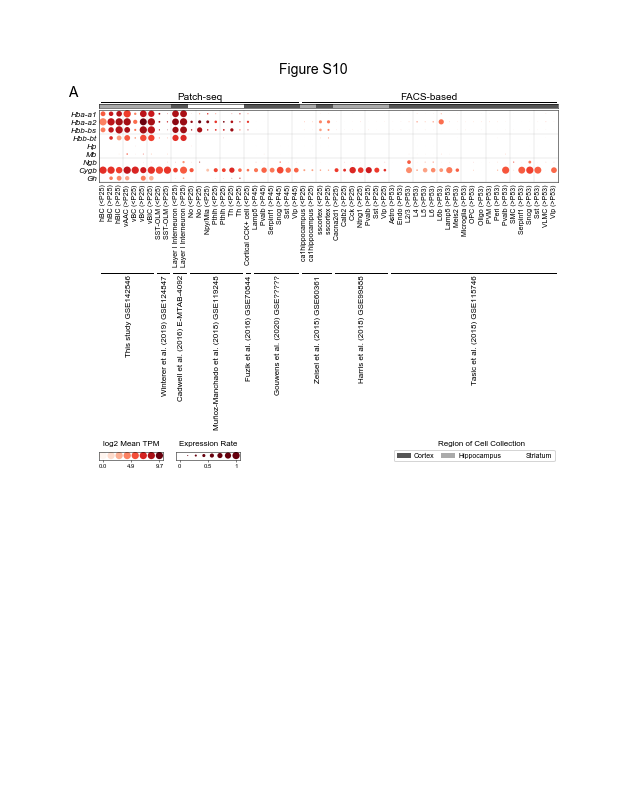

In [5]:
generate_main_figure(df_mean, df_rate, df_labels)